In this assignment we wish to use neural networks to estimate the two dimen- sional distribution of a dependent variable Y = (Y1,Y2) as a function of covariates x1 and x2. Load the file NeuralNetworks.Rdata into R, and you will have four ob- jects, representing 500 observations of two dependent variables Y1 and Y2, and two regressors x1 and x2. Split the data into two parts: the first 400 rows as a training set and the last 100 rows as a test set. Divide the target variables in the same way. Don’t forget to standardize the covariates!

In [176]:
import tensorflow as tf
import numpy as np
import pyreadr
import matplotlib.pyplot as plt
from keras.layers import Dense, Input, Concatenate
from tensorflow.keras.models import Model

## Preliminaries

In [8]:
data = pyreadr.read_r('NeuralNetworks.Rdata')

In [9]:
X = np.hstack((data['x1'], data['x2']))

In [10]:
Y = np.hstack((data['Y1'], data['Y2']))

In [11]:
X_train = X[0:400]
X_test = X[400:]
Y_train = Y[0:400]
Y_test = Y[400:]

In [89]:
X_mean = np.mean(X_train, axis=0)
X_std = np.std(X_train, axis=0)
Y_mean = np.mean(Y_train, axis=0)
Y_std = np.std(Y_train, axis=0)

X_train_n = (X_train - X_mean) / X_std
X_test_n = (X_test - X_mean) / X_std

Y_train_n = (Y_train - Y_mean) / Y_std
Y_test_n = (Y_test - Y_mean) / Y_std

## Question A

Fit a neural network with four (dense) layers: three layers with 30 nodes and one output layer with two nodes. Use a ReLu activation function for the first three layers, and a linear for the last one. Use the mean squared error "mse" as loss function. Determine the mean squared error on the test data for Y1 and Y2 separately.

Use the validation_split option to find the optimal number of epochs. Train on the entire training set for the eventual model (set validation_split to 0.0).

In [217]:
def get_model_dual_output():
    inputs = Input(shape=(2,))
    x = Dense(30, activation='relu')(inputs)
    x = Dense(30, activation='relu')(x)
    x = Dense(30, activation='relu')(x)
    outputs = Dense(2, activation='linear')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

In [374]:
model = get_model_dual_output()
model.fit(X_train_n, Y_train, epochs=750, batch_size=50, verbose=1, validation_split=0.0)

Epoch 1/750
8/8 [==============================] - 1s 3ms/step - loss: 1600.8304
Epoch 2/750
8/8 [==============================] - 0s 2ms/step - loss: 1590.5181
Epoch 3/750
8/8 [==============================] - 0s 2ms/step - loss: 1578.7429
Epoch 4/750
8/8 [==============================] - 0s 3ms/step - loss: 1563.0123
Epoch 5/750
8/8 [==============================] - 0s 3ms/step - loss: 1539.8992
Epoch 6/750
8/8 [==============================] - 0s 3ms/step - loss: 1506.3605
Epoch 7/750
8/8 [==============================] - 0s 4ms/step - loss: 1459.1556
Epoch 8/750
8/8 [==============================] - 0s 3ms/step - loss: 1395.2169
Epoch 9/750
8/8 [==============================] - 0s 3ms/step - loss: 1309.8285
Epoch 10/750
8/8 [==============================] - 0s 3ms/step - loss: 1197.9271
Epoch 11/750
8/8 [==============================] - 0s 3ms/step - loss: 1058.7809
Epoch 12/750
8/8 [==============================] - 0s 3ms/step - loss: 895.0281
Epoch 13/750
8/8 [========

In [375]:
predictions_single_model = model.predict(X_test_n)

4/4 [==============================] - 0s 2ms/step


In [376]:
print(f'MSE model with dual output: {(np.mean(np.square(predictions_single_model - Y_test), axis=0))}')

MSE model with dual output: [9.65766905 1.96881627]


## Question B

Now fit a similar neural network, but only with one output, with Y1 as target variable. Compare the mean squared error on the test data for Y1 with the model from (a). Can you give an explanation for the difference?

In [377]:
def get_model_single_ouput():
    inputs = Input(shape=(2,))
    x = Dense(30, activation='relu')(inputs)  # Look up what the function is of 'relu'
    x = Dense(30, activation='relu')(x)
    x = Dense(30, activation='relu')(x)
    outputs = Dense(1, activation='linear')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

In [381]:
model_2 = get_model_single_ouput()
model_2.fit(X_train_n, Y_train[:, 0], epochs=750, batch_size=50, validation_split=0.0, verbose=1)

Epoch 1/750
8/8 [==============================] - 1s 4ms/step - loss: 2018.6959
Epoch 2/750
8/8 [==============================] - 0s 3ms/step - loss: 2001.9421
Epoch 3/750
8/8 [==============================] - 0s 3ms/step - loss: 1980.8376
Epoch 4/750
8/8 [==============================] - 0s 3ms/step - loss: 1953.0132
Epoch 5/750
8/8 [==============================] - 0s 3ms/step - loss: 1916.3091
Epoch 6/750
8/8 [==============================] - 0s 3ms/step - loss: 1870.2311
Epoch 7/750
8/8 [==============================] - 0s 3ms/step - loss: 1807.9263
Epoch 8/750
8/8 [==============================] - 0s 3ms/step - loss: 1725.6653
Epoch 9/750
8/8 [==============================] - 0s 3ms/step - loss: 1618.1669
Epoch 10/750
8/8 [==============================] - 0s 3ms/step - loss: 1479.8300
Epoch 11/750
8/8 [==============================] - 0s 2ms/step - loss: 1307.3364
Epoch 12/750
8/8 [==============================] - 0s 3ms/step - loss: 1105.4194
Epoch 13/750
8/8 [=======

In [382]:
print(f'MSE model single output: {(np.mean(np.square(model_2.predict(X_test_n, verbose=0)[:, 0] - Y_test[:, 0]), axis=0))}')

MSE model single output: 9.618668442821308


## Question C

Standardize Y1 and Y2 as well, and refit the model. Think of a way to compare the mean squared error of the rescaled targets with the results from (a) and (b).

In [401]:
model_3 = get_model_dual_output()
model_3.fit(X_train_n, Y_train_n, validation_split=0.0, epochs=150, batch_size=50, verbose=1)

Epoch 1/150
8/8 [==============================] - 1s 2ms/step - loss: 0.9910
Epoch 2/150
8/8 [==============================] - 0s 2ms/step - loss: 0.9348
Epoch 3/150
8/8 [==============================] - 0s 2ms/step - loss: 0.8817
Epoch 4/150
8/8 [==============================] - 0s 2ms/step - loss: 0.8280
Epoch 5/150
8/8 [==============================] - 0s 2ms/step - loss: 0.7713
Epoch 6/150
8/8 [==============================] - 0s 3ms/step - loss: 0.7067
Epoch 7/150
8/8 [==============================] - 0s 2ms/step - loss: 0.6487
Epoch 8/150
8/8 [==============================] - 0s 3ms/step - loss: 0.6033
Epoch 9/150
8/8 [==============================] - 0s 2ms/step - loss: 0.5663
Epoch 10/150
8/8 [==============================] - 0s 2ms/step - loss: 0.5430
Epoch 11/150
8/8 [==============================] - 0s 2ms/step - loss: 0.5278
Epoch 12/150
8/8 [==============================] - 0s 2ms/step - loss: 0.5114
Epoch 13/150
8/8 [==============================] - 0s 2ms/st

In [388]:
model_4 = get_model_single_ouput()
model_4.fit(X_train_n, Y_train_n[:, 0], validation_split=0.0, epochs=400, batch_size=50, verbose=1)

Epoch 1/400
8/8 [==============================] - 1s 3ms/step - loss: 0.9763
Epoch 2/400
8/8 [==============================] - 0s 5ms/step - loss: 0.9084
Epoch 3/400
8/8 [==============================] - 0s 4ms/step - loss: 0.8634
Epoch 4/400
8/8 [==============================] - 0s 3ms/step - loss: 0.8219
Epoch 5/400
8/8 [==============================] - 0s 3ms/step - loss: 0.7714
Epoch 6/400
8/8 [==============================] - 0s 3ms/step - loss: 0.7364
Epoch 7/400
8/8 [==============================] - 0s 2ms/step - loss: 0.6934
Epoch 8/400
8/8 [==============================] - 0s 2ms/step - loss: 0.6651
Epoch 9/400
8/8 [==============================] - 0s 2ms/step - loss: 0.6398
Epoch 10/400
8/8 [==============================] - 0s 3ms/step - loss: 0.6186
Epoch 11/400
8/8 [==============================] - 0s 3ms/step - loss: 0.5998
Epoch 12/400
8/8 [==============================] - 0s 3ms/step - loss: 0.5887
Epoch 13/400
8/8 [==============================] - 0s 2ms/st

In [402]:
residuals_model_3 = model_3.predict(X_test_n) * Y_std + Y_mean - Y_test # transform back to original scale
residuals_model_4 = (model_4.predict(X_test_n) * Y_std[0] + Y_mean[0] )[:, 0] - Y_test[:, 0]

4/4 [==============================] - 0s 2ms/step


In [403]:
print((np.mean(np.square(residuals_model_3), axis=0)))
print((np.mean(np.square(residuals_model_4), axis=0)))

[9.5989116  1.69586591]
11.995220098001601


## Question D

In [341]:
def covariance_loss(y_true, y_pred):
    residuals = y_true[:, 0:2]
    residuals = tf.expand_dims(residuals, axis=-1)
    log_variances = y_pred[:, 0:2]
    rho = 2 * ( tf.math.sigmoid(y_pred[:, 2]) - 0.5 )
    variances = tf.math.exp(log_variances) + 1e-6
    det = variances[:, 0] * variances[:, 1] * (1 - tf.square(rho))
    inv_cov_matrix =  tf.stack([
                                tf.stack([variances[:, 1] / det, -rho * tf.sqrt(variances[:, 0] * variances[:, 1]) / det], axis=1),
                                tf.stack([-rho * tf.sqrt(variances[:, 0] * variances[:, 1]) / det, variances[:, 0] / det], axis=1)
                               ], axis=1)
    mahalanobis_dist = tf.transpose(residuals, perm=[0, 2, 1])  @ inv_cov_matrix @ residuals
    log_likelihood = - 0.5 * tf.math.log(det)  - 0.5 * mahalanobis_dist
    return - log_likelihood

In [342]:
def get_covariance_model():
    inputs = Input(shape=(2))
    x = Dense(30, activation='relu')(inputs)  # Look up what the function is of 'relu'
    x = Dense(30, activation='relu')(x)
    x = Dense(30, activation='relu')(x)
    outputs = Dense(3, activation='linear')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss=covariance_loss)
    return model

In [343]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [350]:
covariance_model = get_covariance_model()
train_residuals = model_3.predict(X_train_n) - Y_train_n
covariance_model.fit(X_train_n, train_residuals, epochs=250, batch_size=50)

13/13 [==============================] - 0s 2ms/step
Epoch 1/250
8/8 [==============================] - 1s 2ms/step - loss: 0.1987
Epoch 2/250
8/8 [==============================] - 0s 2ms/step - loss: 0.0778
Epoch 3/250
8/8 [==============================] - 0s 2ms/step - loss: -0.0700
Epoch 4/250
8/8 [==============================] - 0s 2ms/step - loss: -0.2712
Epoch 5/250
8/8 [==============================] - 0s 2ms/step - loss: -0.4711
Epoch 6/250
8/8 [==============================] - 0s 2ms/step - loss: -0.6950
Epoch 7/250
8/8 [==============================] - 0s 2ms/step - loss: -0.7838
Epoch 8/250
8/8 [==============================] - 0s 2ms/step - loss: -0.8630
Epoch 9/250
8/8 [==============================] - 0s 2ms/step - loss: -0.9548
Epoch 10/250
8/8 [==============================] - 0s 2ms/step - loss: -1.0250
Epoch 11/250
8/8 [==============================] - 0s 3ms/step - loss: -1.0832
Epoch 12/250
8/8 [==============================] - 0s 2ms/step - loss: -1.135

In [351]:
covariance_predictions = covariance_model.predict(X_test_n)
covariance_matrix = np.zeros((len(X_test_n), 2,2))
covariance_matrix[:, 0, 0] = np.exp(covariance_predictions[:, 0]) + 1e-6
covariance_matrix[:, 1, 1] = np.exp(covariance_predictions[:, 1]) + 1e-6
rho = (sigmoid(covariance_predictions[:, 1]) - 0.5) * 2
covariance_matrix[:, 0, 1] = covariance_matrix[:, 1, 0] = np.sqrt(covariance_matrix[:, 0, 0] * covariance_matrix[:, 1, 1]) * rho


4/4 [==============================] - 0s 2ms/step


In [352]:
for i in range(5):
    print(covariance_matrix[i])

[[ 0.73657757 -0.24004679]
 [-0.24004679  0.37008384]]
[[ 0.10256924 -0.0812368 ]
 [-0.0812368   0.09369985]]
[[ 0.21752967 -0.13610725]
 [-0.13610725  0.1674661 ]]
[[ 0.05247633 -0.06016127]
 [-0.06016127  0.10523495]]
[[ 0.64466316 -0.23462734]
 [-0.23462734  0.31575689]]


In [353]:
mean_predictions_train = model_3.predict(X_train_n, verbose=0)
covariance_predictions_train = covariance_model.predict(X_train_n, verbose=0)
covariance_matrices_train = np.zeros((len(X_train_n), 2,2))
covariance_matrices_train[:, 0, 0] = np.exp(covariance_predictions_train[:, 0]) + 1e-6
covariance_matrices_train[:, 1, 1] = np.exp(covariance_predictions_train[:, 1]) + 1e-6
rho = (sigmoid(covariance_predictions_train[:, 1]) - 0.5) * 2
covariance_matrices_train[:, 0, 1] = covariance_matrices_train[:, 1, 0] = np.sqrt(covariance_matrices_train[:, 0, 0] * covariance_matrices_train[:, 1, 1]) * rho

## Question E

You now have two neural networks: one to estimate f and one to estimate Σ(x). Run a simulation study where you use the fitted model to simulate new data (based on the same covariates) and refit the regression function and the covariance structure. Evaluate how well the estimators are doing, using the fact that you now know the true regression function and covariance structure. What is your conclusion?

In [368]:
def gen_new_targets(means, covariance_matrices):
    new_targets = np.zeros_like(means)
    for i, m in enumerate(means):
        new_target = np.random.multivariate_normal(m, cov=covariance_matrices[i])
        new_targets[i] = new_target
    return new_targets
new_targets = gen_new_targets(mean_predictions_train, covariance_matrices_train)

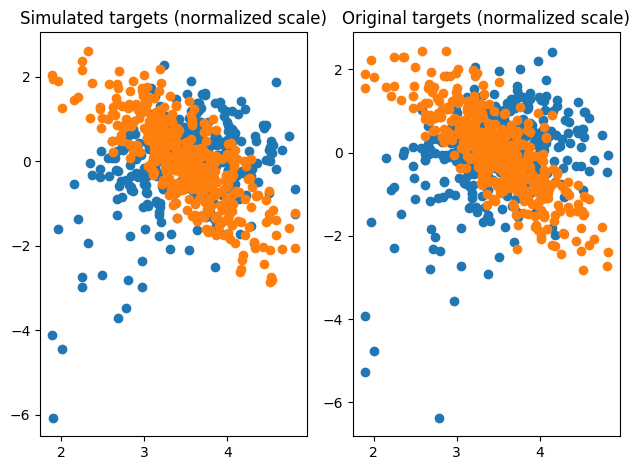

In [369]:
plt.figure(2)
plt.subplot(1, 2, 1)
plt.title('Simulated targets (normalized scale)')
plt.scatter(X_train[:, 1], new_targets[:, 0])
plt.scatter(X_train[:, 1], new_targets[:, 1])
plt.subplot(1, 2, 2)
plt.title('Original targets (normalized scale)')
plt.scatter(X_train[:, 1], Y_train_n[:, 0])
plt.scatter(X_train[:, 1], Y_train_n[:, 1])
plt.tight_layout()
plt.show()

 ## Bonus: Complicated network that does everything

In [356]:
def custom_loglikelihood_loss(y_true, y_pred):
    means = y_pred[:, 0:2]
    log_variances = y_pred[:, 2:4]
    rho = 2 * ( tf.math.sigmoid(y_pred[:, 4]) - 0.5 )
    variances = tf.math.exp(log_variances) + 1e-6
    det = variances[:, 0] * variances[:, 1] * (1 - tf.square(rho))
    inv_cov_matrix =  tf.stack([
                                tf.stack([variances[:, 1] / det, -rho * tf.sqrt(variances[:, 0] * variances[:, 1]) / det], axis=1),
                                tf.stack([-rho * tf.sqrt(variances[:, 0] * variances[:, 1]) / det, variances[:, 0] / det], axis=1)
                               ], axis=1)
    assert np.shape(y_true) == np.shape(means)
    diff = tf.expand_dims(y_true - means, axis=-1)
    mahalanobis_dist = tf.matmul(tf.transpose(diff, perm=[0, 2, 1]), tf.matmul(inv_cov_matrix, diff))
    log_likelihood = - 0.5 * tf.math.log(det)  - 0.5 * mahalanobis_dist
    return - log_likelihood

In [357]:

def get_all_in_one_model():
    inputs = Input(shape=(2))
    x = Dense(30, activation='relu')(inputs)
    x = Dense(30, activation='relu')(x)
    x = Dense(30, activation='relu')(x)
    mu1 = Dense(1, activation='linear')(x)
    var1 = Dense(1)(x)

    y = Dense(30, activation='relu')(inputs)
    y = Dense(30, activation='relu')(y)
    y = Dense(30, activation='relu')(y)
    mu2  = Dense(1, activation='linear')(y)
    var2 = Dense(1, activation='linear')(y)

    rho = Dense(1)(inputs)

    outputs = Concatenate()([mu1, mu2, var1, var2, rho])

    model = Model(inputs=inputs, outputs=outputs)

    # Compile
    model.compile(optimizer='adam', loss=custom_loglikelihood_loss)

    return model

In [359]:
all_in_one_model = get_all_in_one_model()
all_in_one_model.fit(X_train_n, Y_train_n, epochs=500, batch_size=50, verbose=0)

In [360]:
residuals_all_in_one = all_in_one_model.predict(X_test_n)[:, 0:2] * Y_std + Y_mean - Y_test
print(np.mean(np.square(residuals_all_in_one), axis=0))

4/4 [==============================] - 0s 2ms/step
[9.30315761 1.65377394]


In [363]:
covariance_predictions_2 = all_in_one_model.predict(X_test_n, verbose=0)[:, 2:5]
covariance_matrix_2 = np.zeros((len(X_test_n), 2,2))
covariance_matrix_2[:, 0, 0] = np.exp(covariance_predictions_2[:, 0]) + 1e-6
covariance_matrix_2[:, 1, 1] = np.exp(covariance_predictions_2[:, 1]) + 1e-6
rho_2 = (sigmoid(covariance_predictions_2[:, 2]) - 0.5) * 2
covariance_matrix_2[:, 0, 1] = covariance_matrix_2[:, 1, 0] = np.sqrt(covariance_matrix_2[:, 0, 0] * covariance_matrix_2[:, 1, 1]) * rho_2


In [364]:
for i in range(5):
    print(covariance_matrix_2[i])

[[0.61610734 0.40644247]
 [0.40644247 0.27939579]]
[[0.0177713  0.01674312]
 [0.01674312 0.02662902]]
[[0.16827317 0.12870624]
 [0.12870624 0.12028111]]
[[0.03200752 0.03415809]
 [0.03415809 0.06050071]]
[[0.49289387 0.35700674]
 [0.35700674 0.27422655]]


In [365]:
rho_2[0:10]

array([0.9796275 , 0.7696605 , 0.9046768 , 0.7762245 , 0.97105753,
       0.9621433 , 0.97533524, 0.8605015 , 0.9419497 , 0.9530312 ],
      dtype=float32)